[*********************100%***********************]  10 of 10 completed
C:\Users\chrisler.nunes\AppData\Local\Temp\ipykernel_364\4067529123.py:40: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(bt_data, BuyAndHoldPortfolioStrategy, cash=100000, commission=0.002)


Start                     2015-01-02 00:00...
End                       2024-11-13 00:00...
Duration                   3603 days 00:00:00
Exposure Time [%]                   99.917864
Equity Final [$]                468661.849543
Equity Peak [$]                 509190.208683
Return [%]                          368.66185
Buy & Hold Return [%]               361.62452
Return (Ann.) [%]                   17.335052
Volatility (Ann.) [%]               19.775459
Sharpe Ratio                         0.876594
Sortino Ratio                        1.459329
Calmar Ratio                         0.464183
Max. Drawdown [%]                  -37.345314
Avg. Drawdown [%]                   -2.186664
Max. Drawdown Duration      321 days 00:00:00
Avg. Drawdown Duration       25 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     373.182469
Worst Trade [%]                    373.182469
Avg. Trade [%]                    

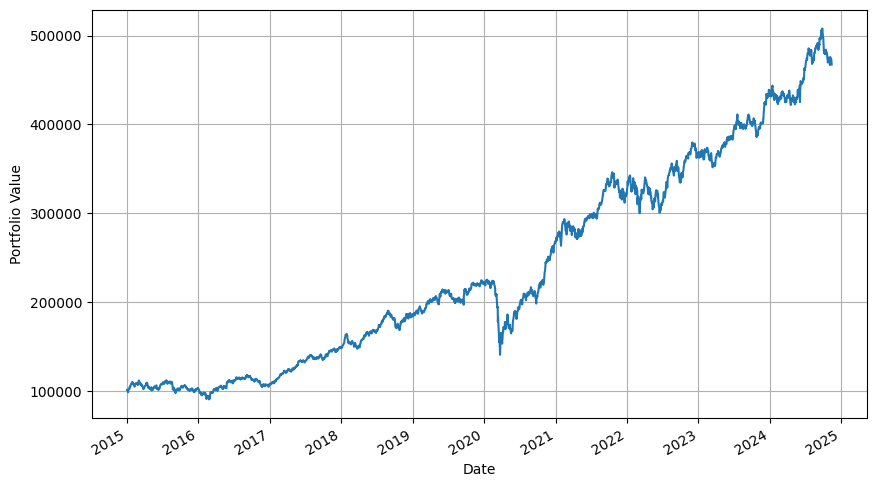

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy


nifty_50_tickers = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "ITC.NS", "KOTAKBANK.NS", "LT.NS", "HINDUNILVR.NS", "AXISBANK.NS"
]

data = yf.download(nifty_50_tickers, start="2015-01-01", end="2024-12-31")['Adj Close']
weights = np.full(len(nifty_50_tickers), 1 / len(nifty_50_tickers))

daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * weights).sum(axis=1)

initial_investment = 100000
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

bt_data = pd.DataFrame({
    'Open': portfolio_value,
    'High': portfolio_value,
    'Low': portfolio_value,
    'Close': portfolio_value,
}, index=portfolio_returns.index)


class BuyAndHoldPortfolioStrategy(Strategy):
    def init(self):
        pass
    
    def next(self):
        # Buy the portfolio on the first day and hold it
        if len(self.trades) == 0:
            self.buy()


bt = Backtest(bt_data, BuyAndHoldPortfolioStrategy, cash=100000, commission=0.002)
stats = bt.run()
print(stats)

plt.figure(figsize=(10, 6))
portfolio_value.plot()

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


In [32]:
rolling_max = portfolio_value.cummax()
drawdown = (portfolio_value - rolling_max) / rolling_max

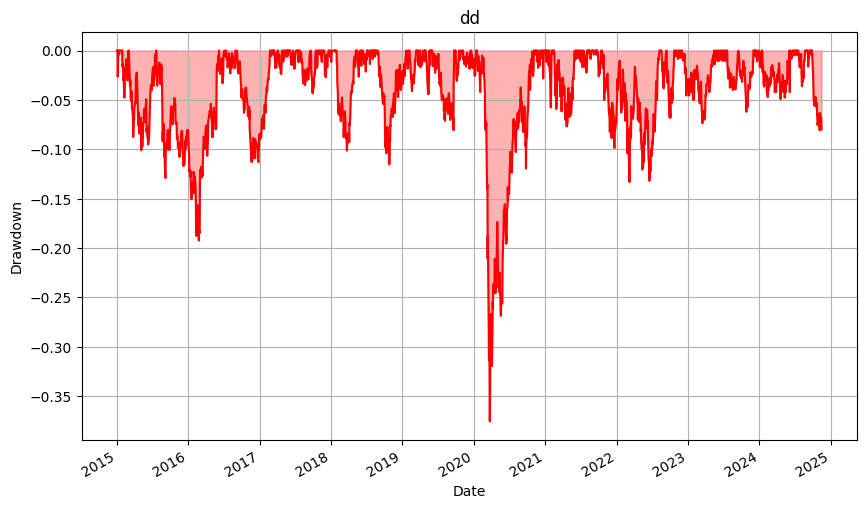

In [33]:
plt.figure(figsize=(10, 6))
drawdown.plot(color="red")
plt.fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.3)
plt.title("dd")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()

In [35]:
monthly_returns = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
yearly_returns = portfolio_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)


monthly_returns_table = monthly_returns.to_frame(name="Monthly Return")
monthly_returns_table['Year'] = monthly_returns_table.index.year
monthly_returns_table['Month'] = monthly_returns_table.index.month

monthly_returns_pivot = monthly_returns_table.pivot(index='Year', columns='Month', values='Monthly Return')


monthly_returns_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


monthly_returns_pivot['Year End Return'] = yearly_returns.values


Monthly Returns for Each Year with Year-End Return:
           Jan       Feb       Mar       Apr       May       Jun       Jul  \
Year                                                                         
2015  0.083590  0.000936 -0.040398 -0.015349  0.029604  0.020140  0.021219   
2016 -0.044174 -0.070428  0.129297  0.014255  0.048700  0.017272  0.028451   
2017  0.023952  0.066664  0.035839  0.016399  0.072476 -0.002307  0.055183   
2018  0.081259 -0.043888 -0.038242  0.092264  0.028199  0.002822  0.071267   
2019  0.032328 -0.015849  0.070502  0.023531  0.026017 -0.002244 -0.037999   
2020 -0.002571 -0.055555 -0.206475  0.127219 -0.035637  0.072982  0.067670   
2021 -0.014175  0.048190  0.023593 -0.020788  0.059758  0.010360 -0.008254   
2022  0.015196 -0.030006  0.034224 -0.015437 -0.002556 -0.041626  0.095673   
2023 -0.013888 -0.002778  0.007271  0.028501  0.027845  0.024971  0.022698   
2024 -0.012667 -0.007170  0.002914  0.000416  0.002739  0.068243  0.049566   

           

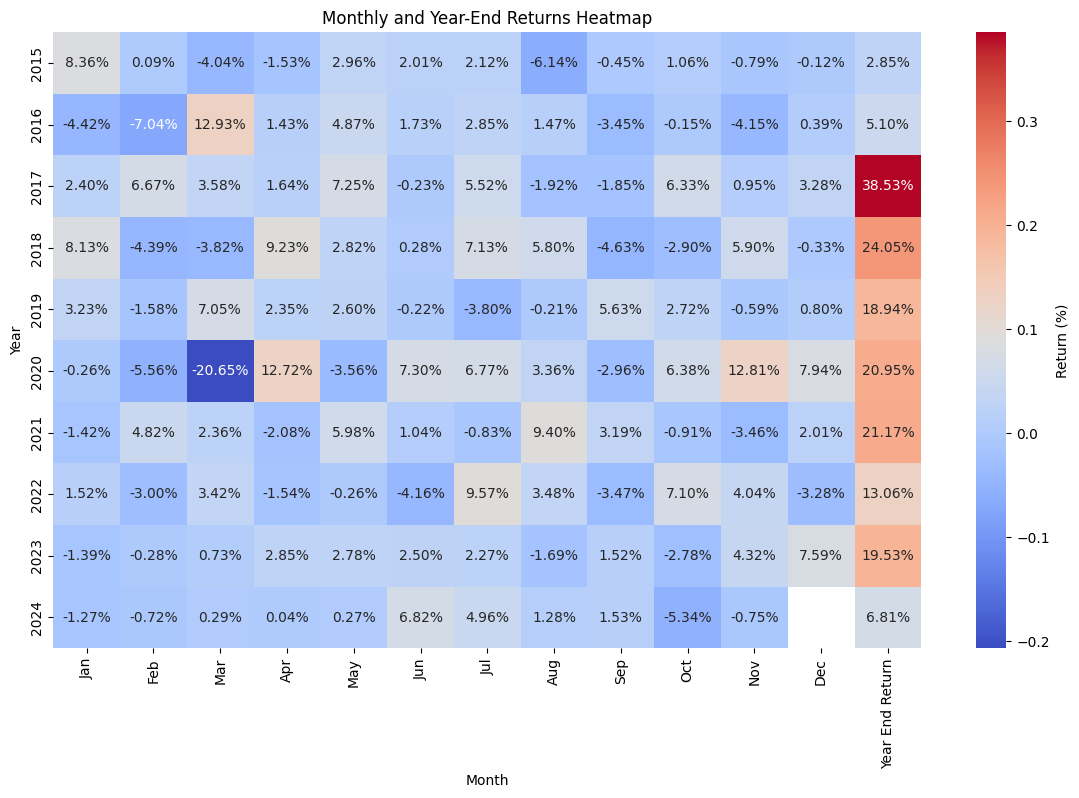

In [36]:
print("Monthly Returns for Each Year with Year-End Return:")
print(monthly_returns_pivot)

import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(monthly_returns_pivot, annot=True, fmt=".2%", cmap="coolwarm", cbar_kws={'label': 'Return (%)'})
plt.title("Monthly and Year-End Returns Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()